In [1]:
# configuring path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/time_series
!pwd

/content/drive/MyDrive/Colab Notebooks/time_series
/content/drive/MyDrive/Colab Notebooks/time_series


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [44]:
# Importing the Keras libraries and packages
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint,EarlyStopping

In [85]:
# load data
df = pd.read_csv('for_time_series_forceasting_pedestrian_count.tsv', sep='\t')
# dataframe hard copy for normalization
df_norm = df.copy()

original data


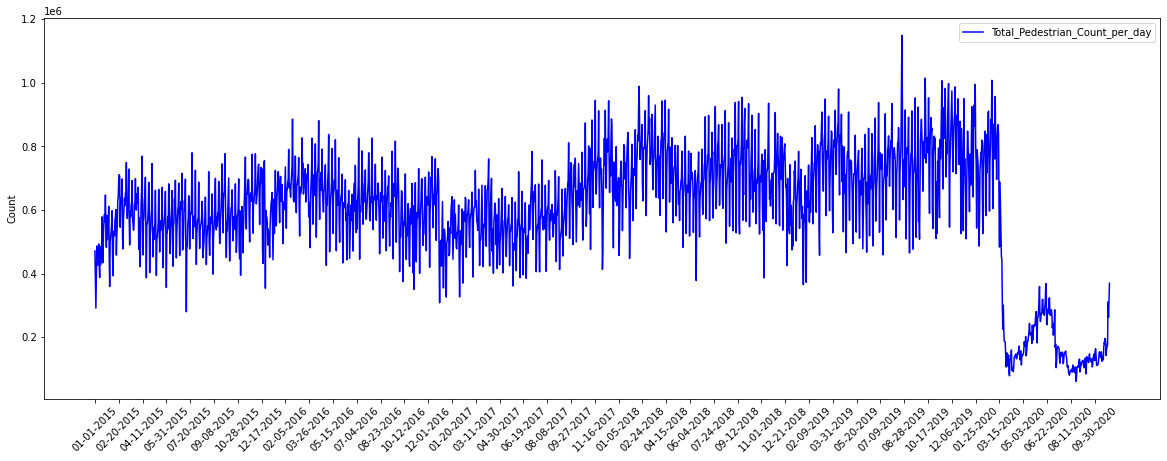

In [86]:
# show pedestrian count each day
print('original data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df)), df['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df),50),df['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()


Normalized data


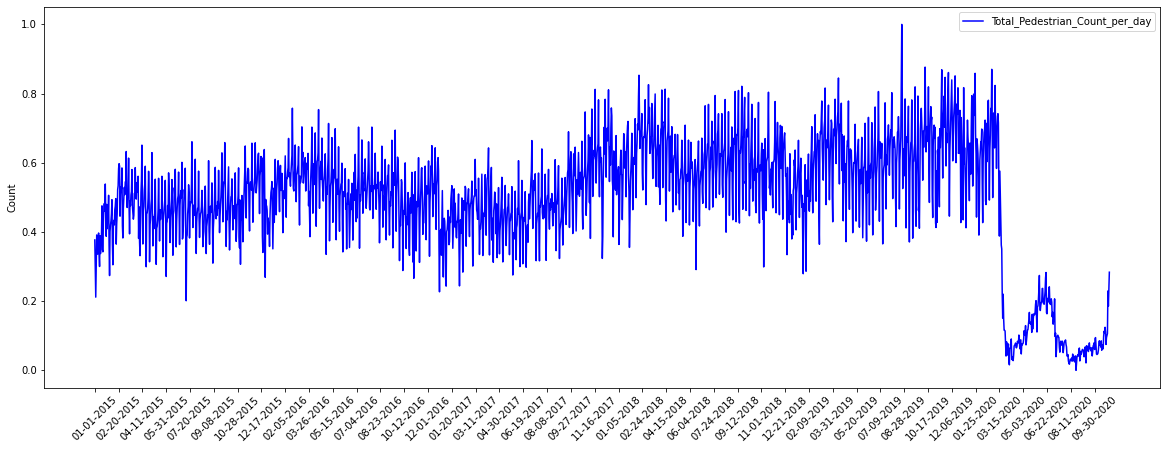

In [87]:
# Data Normalization
scaler = MinMaxScaler()
df_norm.iloc[:,1:] = scaler.fit_transform(df_norm.iloc[:,1:].values)    # normalize feature except the date column
# test_x.iloc[:, 1:] = scaler.transform(test_x.iloc[:, 1:].values)

print('\nNormalized data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df_norm)), df_norm['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df_norm),50),df_norm['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()

In [88]:
df_norm

,Date,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C),Total_Pedestrian_Count_per_day
0,01-01-2015,0.702454,0.0,0.00000,1.0,0.518841,0.463504,0.376885
1,01-02-2015,0.800613,0.0,0.00000,0.0,0.863768,0.540146,0.301011
2,01-03-2015,0.791411,0.0,0.00000,0.0,0.846377,0.708029,0.211554
3,01-04-2015,0.751534,0.0,0.08042,0.0,0.359420,0.572993,0.294865
4,01-05-2015,0.920245,0.0,0.00000,0.0,0.376812,0.525547,0.391282
...,...,...,...,...,...,...,...,...
2127,10-27-2020,0.595092,1.0,0.00000,0.0,0.307246,0.383212,0.106274
2128,10-28-2020,0.797546,1.0,0.00000,0.0,0.344928,0.324818,0.229500
2129,10-29-2020,0.503067,1.0,0.00000,0.0,0.443478,0.386861,0.185415
2130,10-30-2020,0.622699,1.0,0.00000,0.0,0.278261,0.448905,0.231290


In [89]:
n_past = 250           # no of past days used to predict the future
n_future = 10         # no of future days being predicted


x_train = []
y_train = []

for i in range(n_past, len(df_norm)):
	x_train.append(df_norm.iloc[i-n_past:i, 1:].values) # use all column apart from date as feature
	y_train.append(df_norm.iloc[i,-1]) # considering last column as target label

x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)
print('Train data shape: ', x_train.shape)
print('Train Target shape: ', y_train.shape)

Train data shape:  (1882, 250, 7)
Train Target shape:  (1882, 1)


In [90]:
# test on last N days
LAST_N_DAYS = 30

train_x = x_train[:-LAST_N_DAYS,:,:]
train_y = y_train[:-LAST_N_DAYS,:]
print('Train data shape: ', train_x.shape)
print('Train Target shape: ', train_y.shape)

test_x = x_train[-LAST_N_DAYS:,:,:]
test_y = y_train[-LAST_N_DAYS:,:]
print('Test data shape: ', test_x.shape)
print('Test Target shape: ', test_y.shape)

Train data shape:  (1852, 250, 7)
Train Target shape:  (1852, 1)
Test data shape:  (30, 250, 7)
Test Target shape:  (30, 1)


# Simple RNN

Add SimpleRNN model here

In [91]:
def get_model():
  np.random.seed(36)
  model = Sequential()
  model.add(SimpleRNN(75, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(256))
  model.add(Dropout(0.3))
  model.add(Dense(128))
  model.add(Dense(1))
  return model

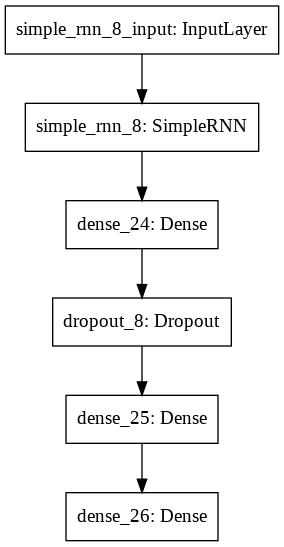

In [51]:
# Model Visualization
model = get_model()
plot_model(model)

In [92]:
model = get_model()
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, verbose=0, mode='min', min_delta=0.0001, min_lr=0.000000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.00001)

tensorboard = TensorBoard(log_dir="logs",write_graph=True)
filepath = './best_rnn_model.hdf5'
model_check_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

LR = 1e-4
EPOCH = 200
opt = Adam(lr=LR, decay=LR/EPOCH)
# opt = Adam(lr=LR)
# opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss='mae')

In [93]:
model_history = model.fit(
                            train_x, train_y, 
                            epochs=EPOCH, 
                            batch_size=128, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [reduce_lr_on_plateau, tensorboard, model_check_point,early_stopping]
                        )

Epoch 1/200
12/12 [==============================] - 5s 352ms/step - loss: 0.3024 - val_loss: 0.2823
Epoch 2/200
12/12 [==============================] - 3s 218ms/step - loss: 0.2145 - val_loss: 0.2083
Epoch 3/200
12/12 [==============================] - 3s 214ms/step - loss: 0.1833 - val_loss: 0.1661
Epoch 4/200
12/12 [==============================] - 3s 222ms/step - loss: 0.1813 - val_loss: 0.1626
Epoch 5/200
12/12 [==============================] - 3s 221ms/step - loss: 0.1613 - val_loss: 0.1421
Epoch 6/200
12/12 [==============================] - 3s 226ms/step - loss: 0.1582 - val_loss: 0.1390
Epoch 7/200
12/12 [==============================] - 3s 221ms/step - loss: 0.1498 - val_loss: 0.1168
Epoch 8/200
12/12 [==============================] - 3s 218ms/step - loss: 0.1433 - val_loss: 0.0947
Epoch 9/200
12/12 [==============================] - 3s 220ms/step - loss: 0.1335 - val_loss: 0.0872
Epoch 10/200
12/12 [==============================] - 3s 220ms/step - loss: 0.1283 - val_lo

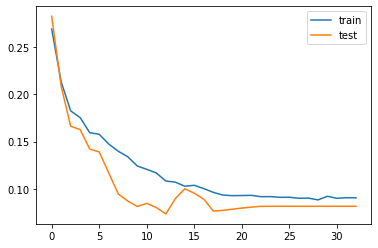

In [94]:
# Plot training loss vs validation loss
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [95]:
# load best rnn model
rnn_best_model = keras.models.load_model(filepath)

In [ ]:
# report error. Benchmark for reference
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.04625543658630555
test MAE error for standard averaging: 0.04963793676829961


In [96]:
# report error
train_pred = rnn_best_model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = rnn_best_model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.0682718898226258
test MAE error for standard averaging: 0.054806545435599166


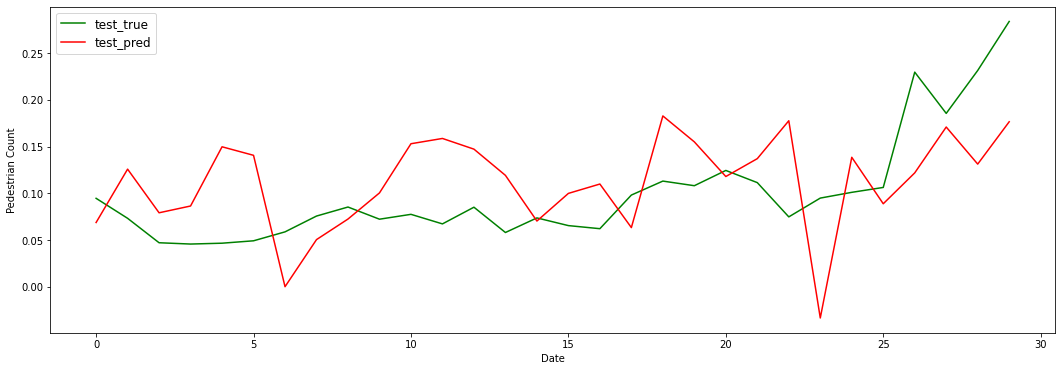

In [97]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.legend(fontsize=12)
plt.show()

In [110]:
# Tabular comparison of predicted vs ground truth
test_scaled = df_norm.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
test_predicted_denorm = scaler.inverse_transform(test_scaled)[:,-1]
test_true_denorm = df.iloc[-LAST_N_DAYS:,-1]

rnn_test_comp = pd.DataFrame(data = {'predicted':test_predicted_denorm, 'ground_truth':test_true_denorm})
rnn_test_comp['diff'] = (rnn_test_comp['predicted']-rnn_test_comp['ground_truth']).abs()
print(rnn_test_comp)
print('-----------------_')
print('Mean diff in prediction and ground truth', np.mean(rnn_test_comp['diff']))

          predicted  ground_truth           diff
2102  136510.964257        164619   28108.035743
2103  198534.491838        141391   57143.491838
2104  147805.072582        112983   34822.072582
2105  155695.766395        111473   44222.766395
2106  224516.683366        112459  112057.683366
2107  214609.358992        115245   99364.358992
2108   61892.355584        125631   63738.644416
2109  116632.198902        144006   27373.801098
2110  140539.598741        154509   13969.401259
2111  170903.086348        140357   30546.086348
2112  228066.116503        146003   82063.116503
2113  234205.818431        134898   99307.818431
2114  221779.755838        154291   67488.755838
2115  191312.885975        124895   66417.885975
2116  138226.928201        141843    3616.071799
2117  170349.421256        132910   37439.421256
2118  181229.700759        129324   51905.700759
2119  130600.487504        168411   37810.512496
2120  260377.029574        184648   75729.029574
2121  230238.415996 

# LSTM

Add LSTM model here

In [80]:
def get_lstm_model():
  np.random.seed(37)
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Dense(128))
  model.add(Dense(1))
  return model

model = get_lstm_model()
opt = Adam(lr=1e-4)
model.compile(optimizer=opt, loss='mae')

model_history = model.fit(
                            train_x, train_y, 
                            epochs=100, 
                            batch_size=64, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [early_stopping, reduce_lr_on_plateau]
                        )

Epoch 1/100
25/25 [==============================] - 2s 29ms/step - loss: 0.3756 - val_loss: 0.1106
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0977 - val_loss: 0.0623
Epoch 3/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0747 - val_loss: 0.0633
Epoch 4/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0705 - val_loss: 0.0632
Epoch 5/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0736 - val_loss: 0.0608
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0766 - val_loss: 0.0652
Epoch 7/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0748 - val_loss: 0.0617
Epoch 8/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0720 - val_loss: 0.0604
Epoch 9/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0696 - val_loss: 0.0621
Epoch 10/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0715 - val_loss: 0.0613

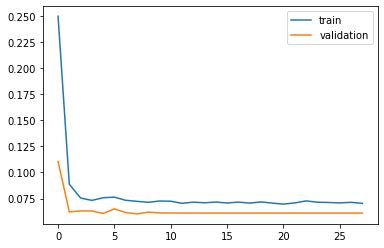

In [82]:
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [83]:
# report error
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.06483747427761659
test MAE error for standard averaging: 0.02680290353680014


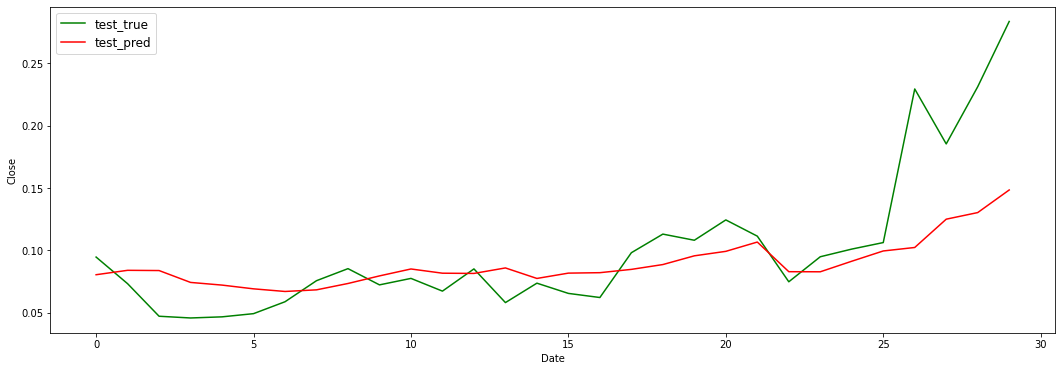

In [84]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(fontsize=12)
plt.show()

In [90]:
test_scaled = df.iloc[-LAST_N_DAYS:,1:-1]
test_scaled['target'] = test_pred
test_scaled
scaler.inverse_transform(test_scaled)[-LAST_N_DAYS:,-1]

,Daily global solar exposure (MJ/m*m),Covid Restrictions,Rainfall amount (millimetres),Public_Holiday,Maximum temperature (Degree C),Minimum temperature (Degree C),target
2102,0.653374,1.0,0.000000,0.0,0.492754,0.445255,0.080476
2103,0.585890,1.0,0.000000,0.0,0.591304,0.613139,0.084010
2104,0.236196,1.0,0.000000,0.0,0.594203,0.470803,0.083826
2105,0.202454,1.0,0.213287,0.0,0.107246,0.310219,0.074298
2106,0.156442,1.0,0.031469,0.0,0.104348,0.302920,0.072151
2107,0.242331,1.0,0.059441,0.0,0.237681,0.346715,0.069150
2108,0.276074,1.0,0.101399,0.0,0.228986,0.394161,0.067042
2109,0.349693,1.0,0.027972,0.0,0.223188,0.405109,0.068346
2110,0.521472,1.0,0.000000,0.0,0.301449,0.372263,0.073446
2111,0.613497,1.0,0.000000,0.0,0.202899,0.397810,0.079531
